In [115]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns
import gcsfs
from pathlib import Path
import yaml
#cartopy text scale issues
sns.set_context('paper', font_scale=.9)

cartopy 0.17.0


### setup data access

In [116]:
gcsfs.core.client_config['installed']['client_id'] = '160816776314-7h1p2h6bqhe77vs1su4rr22fblso9dre.apps.googleusercontent.com'
gcsfs.core.client_config['installed']['client_secret'] = 'SrJUwD58yKgViyJtw-NP2sz8'

In [117]:
# create a GCSFileSystem just for the purpose of authentication
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# create another one with those credentials
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)

### setup data

In [118]:
staging_dir = Path("vo_agam_release")
species_analysis = "species_calls_20200422"

In [119]:
#get pops
with open("../data/config.yml", "r") as yy:
    config = yaml.load(yy, Loader=yaml.Loader)

samplesets = sorted(config["sample_sets"])

#GA-B is empty, crosses we don't want
samplesets.remove('AG1000G-GA-B')
samplesets.remove('AG1000G-X')

In [120]:
#country centroids
df_centroids =  pd.read_csv('../data/Africa_centroids.csv', index_col=0)

In [121]:
#need to get mean lon/lat across countries so we might as well concat all metadata including species into a big PD
set_len = 0
all_meta = pd.DataFrame()

for sset in samplesets:
        
        metadata_path = staging_dir / "v3" / "metadata" / "general" / sset / "samples.meta.csv"
        species_path = staging_dir / "v3" / "metadata" / species_analysis / sset / "samples.species_aim.csv"


        with gcs.open(metadata_path) as gcs_fh:
            df = pd.read_csv(gcs_fh, index_col=0)
        with gcs.open(species_path) as gcs_fh:
            df_aim = pd.read_csv(gcs_fh, index_col=0)

        # join on sample id
        result = pd.concat([df, df_aim], axis=1, sort=False)
        set_len += len(result)

        all_meta = pd.concat([all_meta, result],sort=False)

assert len(all_meta) == set_len

In [122]:
#make The Gambia presentable
all_meta = all_meta.replace('Gambia, The', 'The Gambia')
all_meta = all_meta.replace('Equatorial Guinea', 'Bioko')

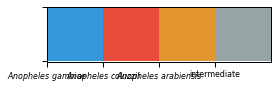

In [123]:
#countries
countries = list(all_meta.country.unique())
#long species labels
sp_nm = ['$Anopheles$ $gambiae$', '$Anopheles$ $coluzzii$', '$Anopheles$ $arabiensis$', 'intermediate']
#palette
flat = ["#3498db", "#e74c3c", "#e2962d", "#95a5a6"]
palette = sns.color_palette(flat, n_colors=len(sp_nm))
# add a colour for other_resistant
sns.palplot(palette)
plt.gca().set_xticklabels(sp_nm);

In [170]:
#build df with lat lon offsets and country labels - two letter codes?
offset_df = pd.DataFrame()
offset_df['country'] = countries
#make lonlat offsets, label position exceptions 
offset_df['offset_lon'] = np.zeros(len(offset_df))
offset_df['offset_lat'] = np.zeros(len(offset_df))
offset_df['label'] = 'top'
offset_df['name'] = '?'
offset_df['long'] = list(offset_df['country'])

#angola
offset_df.loc[offset_df.country == 'Angola', 'offset_lon'] = 0
offset_df.loc[offset_df.country == 'Angola', 'offset_lat'] = 1
offset_df.loc[offset_df.country == 'Angola', 'name'] = 'AO'
#burkina faso
offset_df.loc[offset_df.country == 'Burkina Faso', 'offset_lon'] = 2
offset_df.loc[offset_df.country == 'Burkina Faso', 'offset_lat'] = 0
offset_df.loc[offset_df.country == 'Burkina Faso', 'name'] = 'BF'
#cameroon
offset_df.loc[offset_df.country == 'Cameroon', 'offset_lon'] = -0.3
offset_df.loc[offset_df.country == 'Cameroon', 'offset_lat'] = 1
offset_df.loc[offset_df.country == 'Cameroon', 'name'] = 'CM'
offset_df.loc[offset_df.country == 'Cameroon', 'label'] = 'bottom'

#central african republic
offset_df.loc[offset_df.country == 'Central African Republic', 'offset_lon'] = 0.3
offset_df.loc[offset_df.country == 'Central African Republic', 'offset_lat'] = 1
offset_df.loc[offset_df.country == 'Central African Republic', 'name'] = 'CF'
offset_df.loc[offset_df.country == 'Central African Republic', 'long'] = 'Central\nAfrican\nRepublic'
offset_df.loc[offset_df.country == 'Central African Republic', 'label'] = 'bottom'

#cote d'ivoire
offset_df.loc[offset_df.country == "Cote d'Ivoire", 'offset_lon'] = -0.5
offset_df.loc[offset_df.country == "Cote d'Ivoire", 'offset_lat'] = 0
offset_df.loc[offset_df.country == "Cote d'Ivoire", 'name'] = 'CI'
offset_df.loc[offset_df.country == "Cote d'Ivoire", 'long'] = "Cote\nd'Ivoire"

#democratic republic of congo
offset_df.loc[offset_df.country == 'Democratic Republic of Congo', 'offset_lon'] = 0
offset_df.loc[offset_df.country == 'Democratic Republic of Congo', 'offset_lat'] = 3
offset_df.loc[offset_df.country == 'Democratic Republic of Congo', 'name'] = 'CD'
offset_df.loc[offset_df.country == 'Democratic Republic of Congo', 'long'] = 'Democratic\nRepublic\nof Congo'

#equatorial guinea
offset_df.loc[offset_df.country == 'Bioko', 'offset_lon'] = -3
offset_df.loc[offset_df.country == 'Bioko', 'offset_lat'] = -1.5
offset_df.loc[offset_df.country == 'Bioko', 'name'] = 'GQ'
offset_df.loc[offset_df.country == 'Bioko', 'long'] = 'Bioko\nisland'


#gabon
offset_df.loc[offset_df.country == 'Gabon', 'offset_lon'] = 0
offset_df.loc[offset_df.country == 'Gabon', 'offset_lat'] = 0
offset_df.loc[offset_df.country == 'Gabon', 'name'] = 'GA'
#gambia
offset_df.loc[offset_df.country == 'The Gambia', 'offset_lon'] = -4
offset_df.loc[offset_df.country == 'The Gambia', 'offset_lat'] = 1
offset_df.loc[offset_df.country == 'The Gambia', 'name'] = 'GM'
offset_df.loc[offset_df.country == 'The Gambia', 'label'] = 'bottom'
offset_df.loc[offset_df.country == 'The Gambia', 'long'] = 'The\nGambia'

#ghana
offset_df.loc[offset_df.country == 'Ghana', 'offset_lon'] = 0.4
offset_df.loc[offset_df.country == 'Ghana', 'offset_lat'] = -1.5
offset_df.loc[offset_df.country == 'Ghana', 'name'] = 'GH'
#guinea
offset_df.loc[offset_df.country == 'Guinea', 'offset_lon'] = 0
offset_df.loc[offset_df.country == 'Guinea', 'offset_lat'] = 0
offset_df.loc[offset_df.country == 'Guinea', 'name'] = 'GN'
offset_df.loc[offset_df.country == 'Guinea', 'label'] = 'bottom'

#guinea bissau
offset_df.loc[offset_df.country == 'Guinea-Bissau', 'offset_lon'] = -2.5
offset_df.loc[offset_df.country == 'Guinea-Bissau', 'offset_lat'] = -3
offset_df.loc[offset_df.country == 'Guinea-Bissau', 'name'] = 'GW'
#kenya
offset_df.loc[offset_df.country == 'Kenya', 'offset_lon'] = 0
offset_df.loc[offset_df.country == 'Kenya', 'offset_lat'] = 1
offset_df.loc[offset_df.country == 'Kenya', 'name'] = 'KE'
#malawi
offset_df.loc[offset_df.country == 'Malawi', 'offset_lon'] = -1
offset_df.loc[offset_df.country == 'Malawi', 'offset_lat'] = 0
offset_df.loc[offset_df.country == 'Malawi', 'name'] = 'MW'
#mali
offset_df.loc[offset_df.country == 'Mali', 'offset_lon'] = 0
offset_df.loc[offset_df.country == 'Mali', 'offset_lat'] = -1
offset_df.loc[offset_df.country == 'Mali', 'name'] = 'ML'
offset_df.loc[offset_df.country == 'Mali', 'label'] = 'bottom'

#mayotte
offset_df.loc[offset_df.country == 'Mayotte', 'offset_lon'] = -1
offset_df.loc[offset_df.country == 'Mayotte', 'offset_lat'] = 3
offset_df.loc[offset_df.country == 'Mayotte', 'label'] = 'bottom'
offset_df.loc[offset_df.country == 'Mayotte', 'name'] = 'FR'
offset_df.loc[offset_df.country == 'Mayotte', 'long'] = 'Mayotte\nisland'

#mozambique
offset_df.loc[offset_df.country == 'Mozambique', 'offset_lon'] = 1
offset_df.loc[offset_df.country == 'Mozambique', 'offset_lat'] = -2
offset_df.loc[offset_df.country == 'Mozambique', 'name'] = 'MZ'
#tanzania
offset_df.loc[offset_df.country == 'Tanzania', 'offset_lon'] = 0
offset_df.loc[offset_df.country == 'Tanzania', 'offset_lat'] = 1
offset_df.loc[offset_df.country == 'Tanzania', 'name'] = 'TZ'
#Uganda
offset_df.loc[offset_df.country == 'Uganda', 'offset_lon'] = 0
offset_df.loc[offset_df.country == 'Uganda', 'offset_lat'] = 1
offset_df.loc[offset_df.country == 'Uganda', 'name'] = 'UG'
offset_df.loc[offset_df.country == 'Uganda', 'label'] = 'bottom'


offset_df

,country,offset_lon,offset_lat,label,name,long
0,Angola,0.0,1.0,top,AO,Angola
1,Burkina Faso,2.0,0.0,top,BF,Burkina Faso
2,Democratic Republic of Congo,0.0,3.0,top,CD,Democratic\nRepublic\nof Congo
3,Central African Republic,0.3,1.0,bottom,CF,Central\nAfrican\nRepublic
4,Cote d'Ivoire,-0.5,0.0,top,CI,Cote\nd'Ivoire
5,Cameroon,-0.3,1.0,bottom,CM,Cameroon
6,Mayotte,-1.0,3.0,bottom,FR,Mayotte\nisland
7,Gabon,0.0,0.0,top,GA,Gabon
8,Ghana,0.4,-1.5,top,GH,Ghana
9,The Gambia,-4.0,1.0,bottom,GM,The\nGambia


##' 

In [181]:
#code to get a single averaged lat/lon and species composition for each country
def plot_pyr_map(dpi=150, extent=[-23, 48, -20, 17.5], figsize=(10, 4), label_fontsize=7):
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=120)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=0.7, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=5)
    
    for c in countries:
        df = all_meta[all_meta.country == c]
        ar = 0
        gm = 0
        cl = 0
        it = 0
        #species counts
        spai = df.species_gambcolu_arabiensis.value_counts()
        if 'arabiensis' in spai:
            ar += spai.arabiensis
        if 'intermediate' in spai:
            it += spai.intermediate

        spgc = df.species_gambiae_coluzzii.value_counts()
        if 'gambiae' in spgc:
            gm += spgc.gambiae
        if 'intermediate' in spgc:
            it += spgc.intermediate
        if 'coluzzii' in spgc:
            cl += spgc.coluzzii

        #check
        tot = ar + gm + cl + it
        assert(tot == len(df))
#         print(c, ar, gm, cl, it)
        
        #get an average lonlat for each country
#         lon = np.mean(df.longitude.unique())
#         lat = np.mean(df.latitude.unique())
        #use centroids for countries +- offsets
        offset_lon = offset_df[offset_df.country == c].offset_lon.values[0]
        offset_lat = offset_df[offset_df.country == c].offset_lat.values[0]
        lon = df_centroids[df_centroids.index == c].Longitude[0]
        lat = df_centroids[df_centroids.index == c].Latitude[0]
#         print(c, lon, lat, offset_lon, offset_lat)

        centre = (lon + offset_lon, lat + offset_lat)
        radius= np.sqrt(len(df) * .02)
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=1))
        ax.pie([gm, cl, ar, it], wedgeprops=dict(zorder=7), colors=palette, center=centre, radius=radius, shadow=True)
        
        if offset_df[offset_df.country == c].label.values[0] == 'bottom':
            ax.text(centre[0], centre[1] + (radius + (0.1 * radius)), offset_df[offset_df.country == c].long.values[0], ha='center', va='bottom', fontsize=6, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), zorder=6)
        if offset_df[offset_df.country == c].label.values[0] == 'top':
            ax.text(centre[0], centre[1] - (radius + (0.1 * radius)), offset_df[offset_df.country == c].long.values[0], ha='center', va='top', fontsize=6, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), zorder=6)
        
        if offset_lat != 0 or offset_lon != 0:
            ax.plot([lon, lon + offset_lon],[lat, lat + offset_lat], 'k-', lw=1, zorder=5)
            
        
    
    #manual colour legend
    plt.text(-12.0, -1.3, 'Species', fontsize=8,fontweight='bold')
    
    plt.plot([-14.5, -17.6],[-4, -4], color=flat[0], lw=8, zorder=20, solid_capstyle='round')
    plt.text(-13,-4.7,  sp_nm[0], fontsize=8 )
    
    plt.plot([-14.5, -17.6],[-7, -7], color=flat[1], lw=8, zorder=20, solid_capstyle='round')
    plt.text(-13,-7.7, sp_nm[1], fontsize=8 )
    
    plt.plot([-14.5, -17.6],[-10, -10], color=flat[2], lw=8, zorder=20, solid_capstyle='round')
    plt.text(-13,-10.7, sp_nm[2], fontsize=8 )
    
    plt.plot([-14.5, -17.6],[-13, -13], color=flat[3], lw=8, zorder=20, solid_capstyle='round')
    plt.text(-13,-13.7, sp_nm[3], fontsize=8 )
    
    
    #cover tiny islands
    plt.plot([-17, -15],[-6.5, -6.5], 'w', lw=20, zorder=10)
    plt.plot([-6.5, -6],[-15, -15], 'w', lw=20, zorder=3)      

    #X0,X1,Y0,Y1  extent format  
    ax.set_extent(extent)         
    fig.savefig('../artwork/collection_map.pdf', dpi=dpi, bbox_inches='tight');

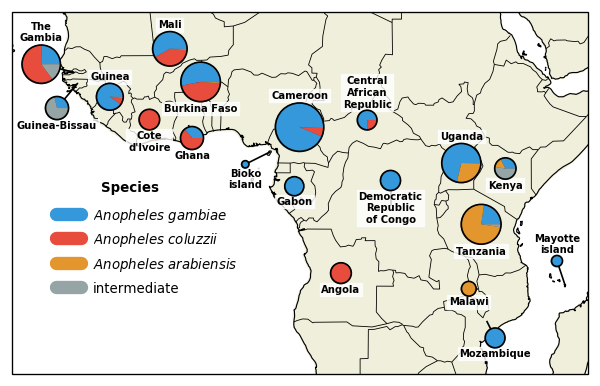

In [182]:
plot_pyr_map()

## to do 
- point to bioko not mainland guinea bissau?